## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: Compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#print(objp)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()


Now I have the objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image

## Step 2: Apply a distortion correction to raw images

test image shape: (720, 1280, 3)
img_size:  (1280, 720)
distortion coefficients:
 [[-2.41017956e-01 -5.30721173e-02 -1.15810355e-03 -1.28318856e-04
   2.67125290e-02]]
camera matrix:
 [[1.15396093e+03 0.00000000e+00 6.69705357e+02]
 [0.00000000e+00 1.14802496e+03 3.85656234e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


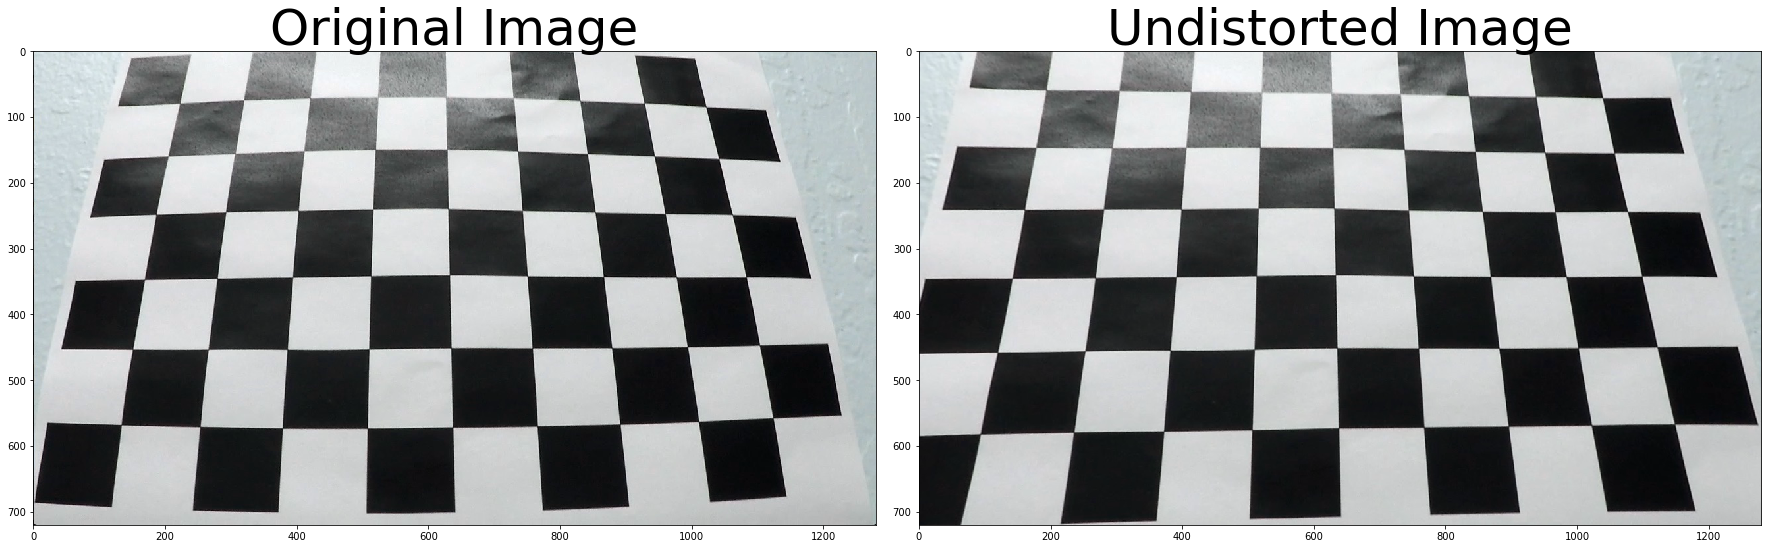

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
#img = cv2.imread('test_images/test1.jpg')
# height, width, channels = img.shape
print('test image shape:', img.shape)
# (width, height), corrresponding to (9,6)
img_size = (img.shape[1], img.shape[0])
print('img_size: ', img_size)


def image_undistort(img):
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst

def show_images(image1, image2, image1_exp="Image1", image2_exp="Image2", mode1 = None, mode2 = None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1,cmap = mode1)
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2,cmap = mode2)
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def camera_calibration(objpoints,imgpoints,img_size):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    print('distortion coefficients:\n', dist)
    print('camera matrix:\n', mtx)
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )


camera_calibration(objpoints,imgpoints,img_size)
undst = image_undistort(img)
cv2.imwrite('camera_cal/test_undist.jpg',undst)

# Visualize undistortion
show_images(img,undst,'Original Image','Undistorted Image')


In [29]:
image = mpimg.imread('test_images/straight_lines1.jpg')
image = image_undistort(image)

## Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

**Gradient Thresholds**

(720, 1280, 3)
(720, 1280)


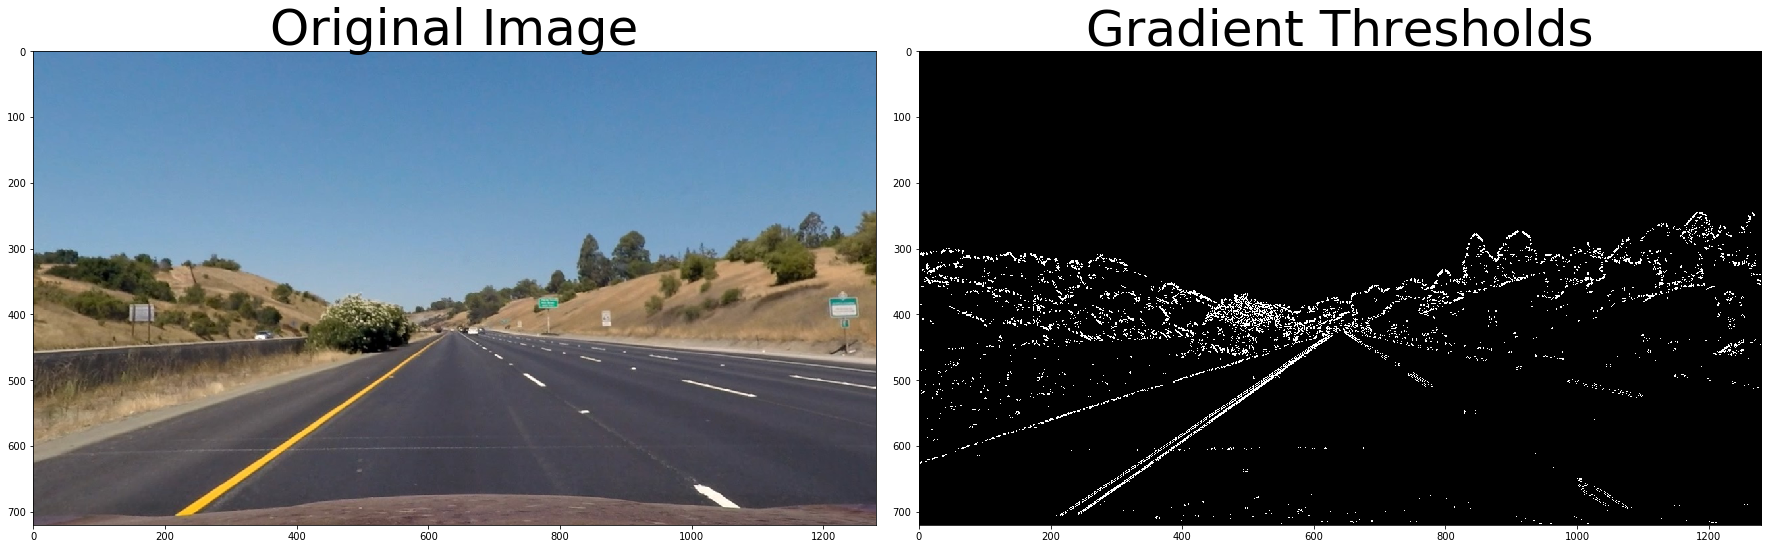

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline


# Read in an image
#image = mpimg.imread('test_images/test3.jpg')
print(image.shape)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary= np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely,abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary
    

def grad_threshold(img, ksize = 3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

combined = grad_threshold(image)
print(combined.shape)
show_images(image,combined,'Original Image','Gradient Thresholds', mode2 = 'gray')


**HLS and Color Thresholds**

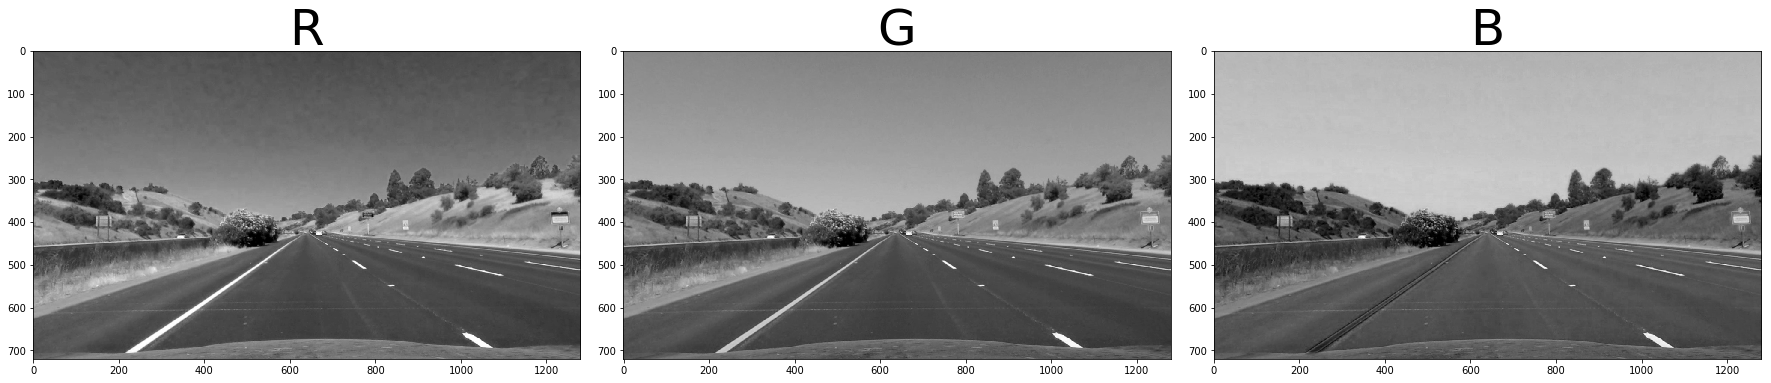

In [31]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap = 'gray')
ax1.set_title('R', fontsize=50)
ax2.imshow(G, cmap='gray')
ax2.set_title('G', fontsize=50)
ax3.imshow(B, cmap='gray')
ax3.set_title('B', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

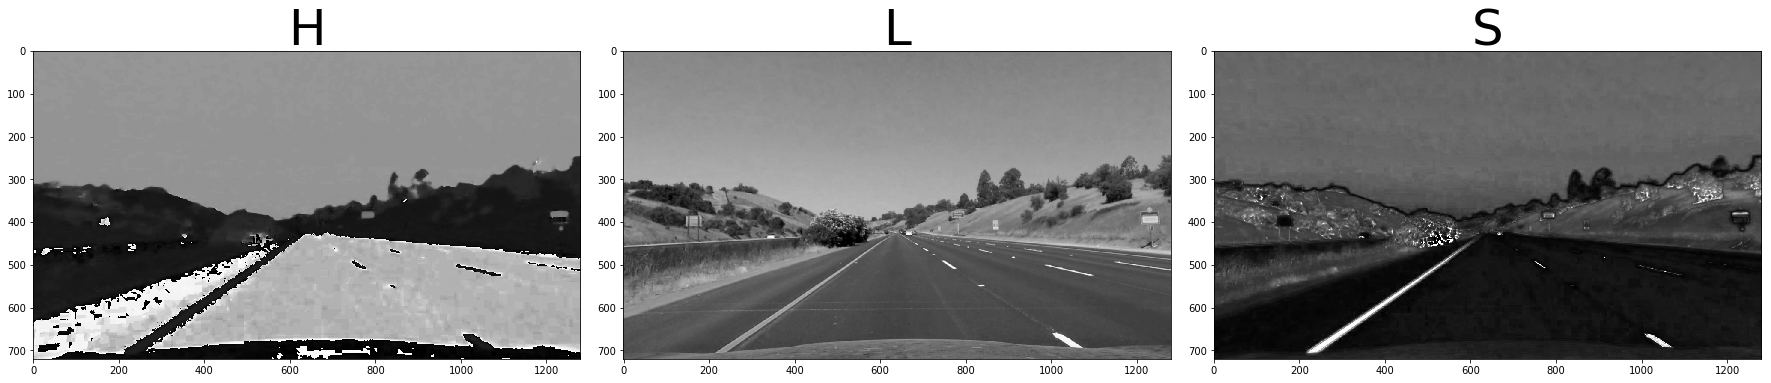

In [32]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap = 'gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(L, cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(S, cmap='gray')
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**The S channel picks up the lines well, so let's try applying a threshold there:**

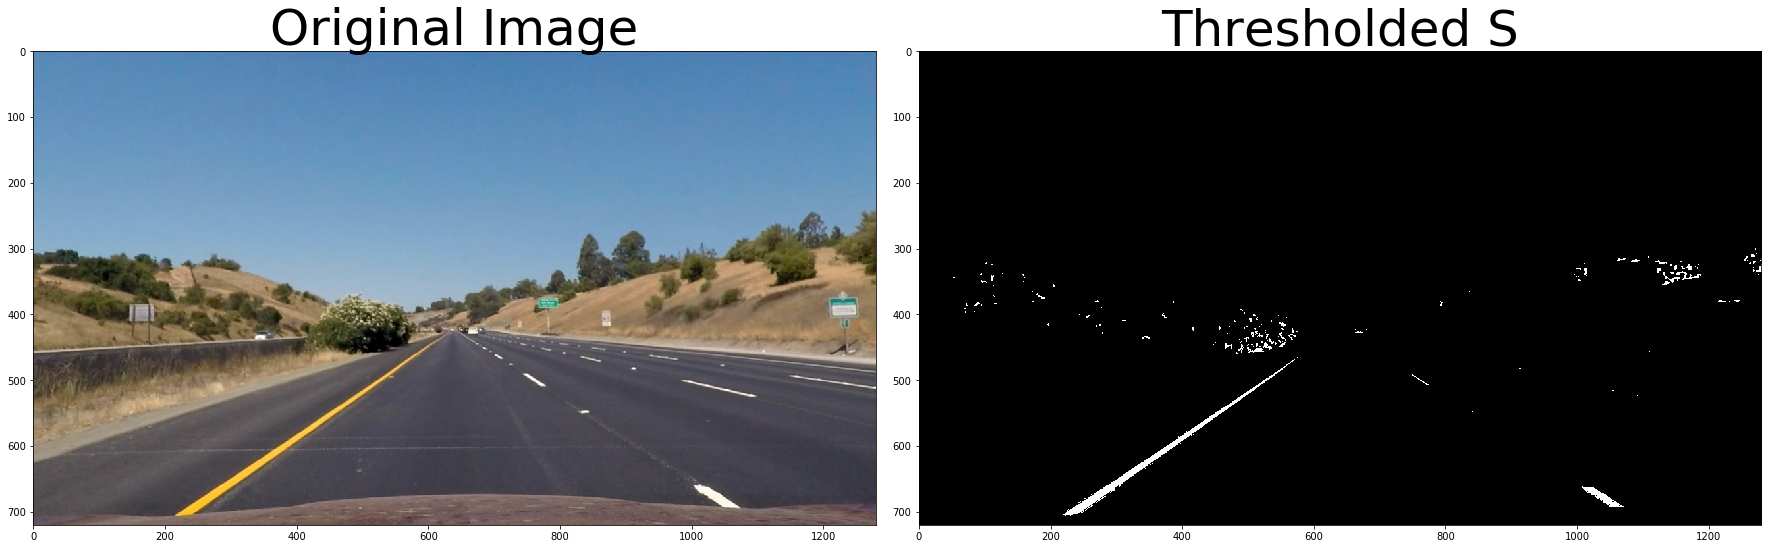

In [33]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

s_binary = hls_select(image, thresh=(170, 255))
#print(s_binary.shape)
show_images(image,s_binary,'Original Image','Thresholded S',mode2='gray')



**Combine Color and Gradient**

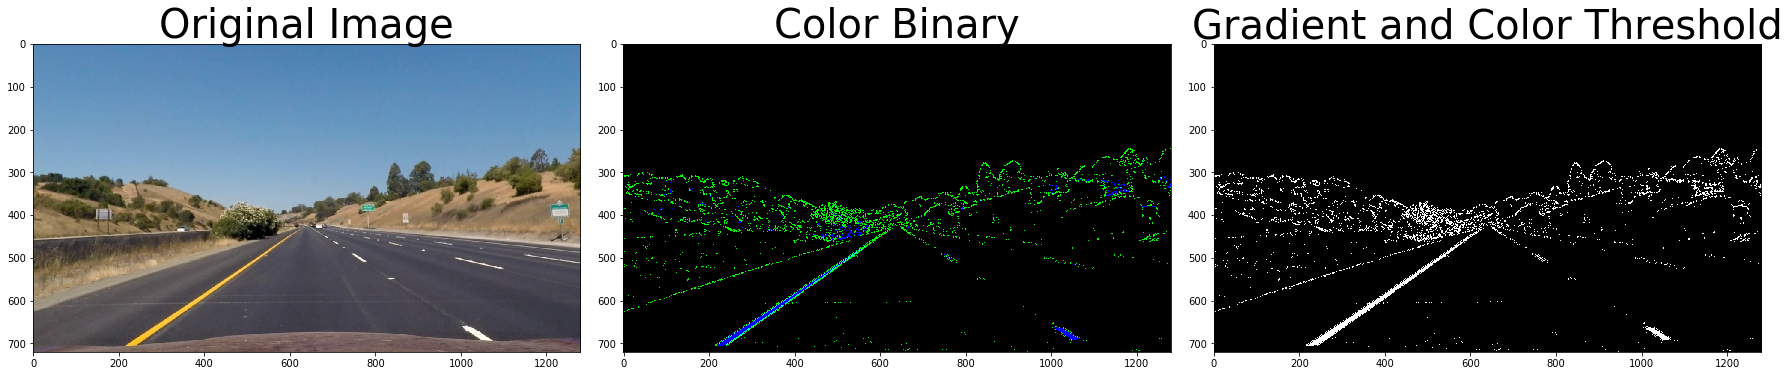

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Edit this function to create your own pipeline.
def combine_threshold(s_binary, combined):    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    
    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary)) * 255
    color_binary = color_binary.astype(np.uint8)

    return color_binary, combined_binary
    
color_binary, combined_binary = combine_threshold(s_binary, combined)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Color Binary', fontsize=40)

ax3.imshow(combined_binary, cmap = 'gray')
ax3.set_title('Gradient and Color Threshold', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 685, 450      | 900, 0        | 
| 1090, 710     | 900, 710      |
| 220, 710      | 250, 710      |
| 595, 450      | 250, 0        |

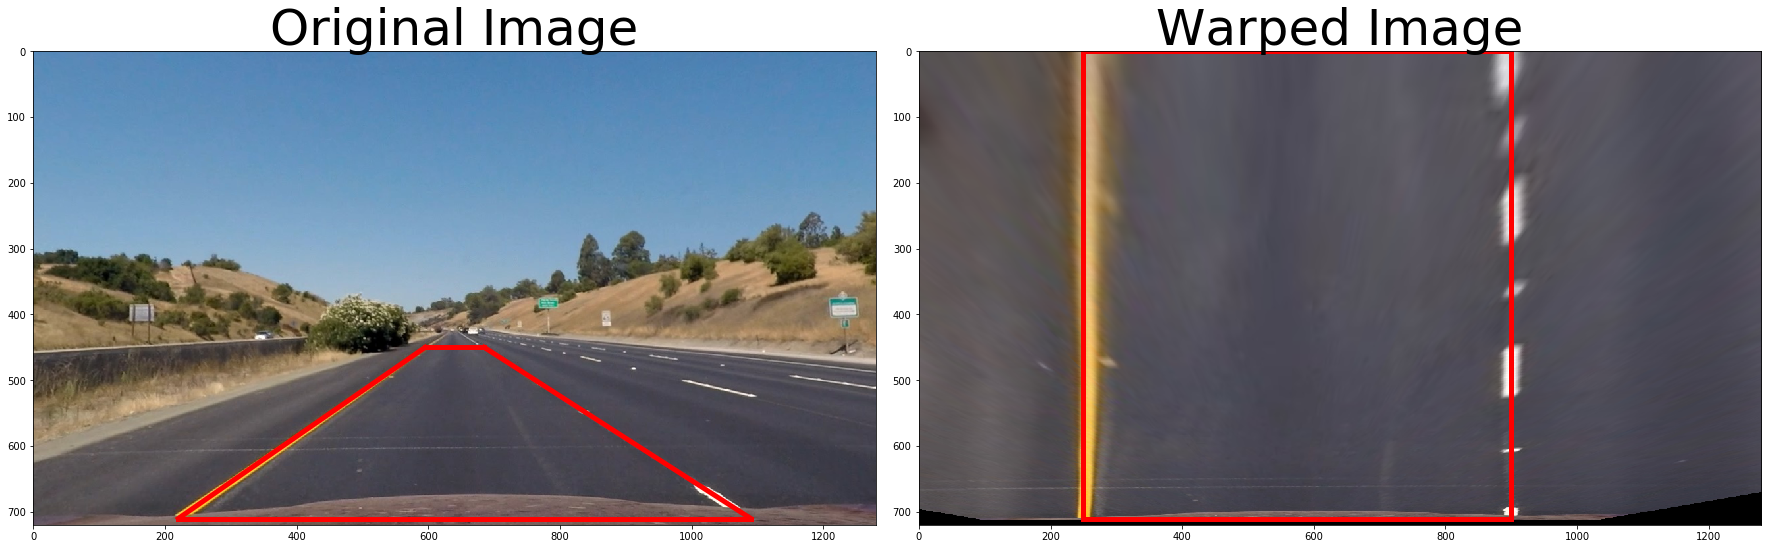

In [35]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # define four source points, clockwise from top-right to top-left
    right_top = [685, 450]
    right_bottom = [1090, 710]
    left_bottom = [220, 710]
    left_top = [595, 450]
    src = np.float32([right_top,right_bottom,left_bottom,left_top])
    
    # define four source points, clockwise from top-right to top-left
    right_top_dst = [900,0]
    right_bottom_dst = [900, 710]
    left_bottom_dst = [250, 710]
    left_top_dst = [250, 0]
    dst = np.float32([right_top_dst,right_bottom_dst,left_bottom_dst,left_top_dst])
    
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    #print('Perspective Transform Matrix:\n', M)

    return binary_warped, Minv

def plotted_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    right_top = [685, 450]
    right_bottom = [1090, 710]
    left_bottom = [220, 710]
    left_top = [595, 450]
    
    right_top_dst = [900,0]
    right_bottom_dst = [900, 710]
    left_bottom_dst = [250, 710]
    left_top_dst = [250, 0]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.plot([right_top[0], right_bottom[0]], [right_top[1], right_bottom[1]], color='r', linewidth="5")
    ax1.plot([right_bottom[0], left_bottom[0]], [right_bottom[1], left_bottom[1]], color='r', linewidth="5")
    ax1.plot([left_bottom[0], left_top[0]], [left_bottom[1], left_top[1]], color='r', linewidth="5")
    ax1.plot([left_top[0], right_top[0]], [left_top[1], right_top[1]], color='r', linewidth="5")
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.plot([right_top_dst[0], right_bottom_dst[0]], [right_top_dst[1], right_bottom_dst[1]], color='r', linewidth="5")
    ax2.plot([right_bottom_dst[0], left_bottom_dst[0]], [right_bottom_dst[1], left_bottom_dst[1]], color='r', linewidth="5")
    ax2.plot([left_bottom_dst[0], left_top_dst[0]], [left_bottom_dst[1], left_top_dst[1]], color='r', linewidth="5")
    ax2.plot([left_top_dst[0], right_top_dst[0]], [left_top_dst[1], right_top_dst[1]], color='r', linewidth="5")
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


warped, Minv = warp(image)
plotted_images(image, warped, "Original Image", "Warped Image")

## Step 5: Finding Lane Lines

**Histogram**

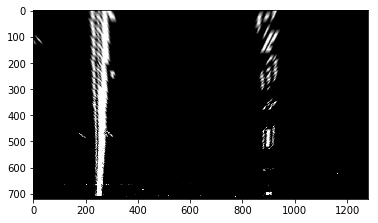

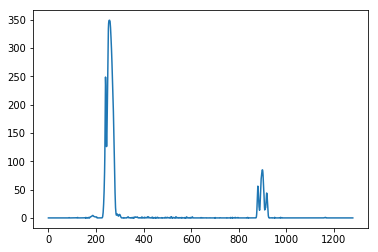

In [36]:
def plot_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    return histogram

binary_warped, Minv = warp(combined_binary)
histogram = plot_histogram(binary_warped)
plt.imshow(binary_warped, cmap = 'gray')
plt.show()
plt.plot(histogram)


**Sliding Window**

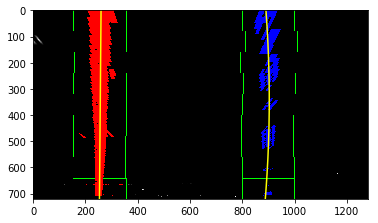

In [37]:
def slide_window(binary_warped, histogram, draw = True):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if draw == True:
        out_img = out_img.astype(np.uint8)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit
left_fit, right_fit = slide_window(binary_warped, histogram)

**Skipping Sliding window**

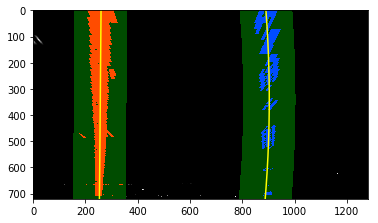

In [38]:
def skipping_sliding_window(binary_warped, left_fit, right_fit, draw = True):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if draw == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = out_img.astype(np.uint8)
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    record = {}
    record['leftx'] = leftx
    record['rightx'] = rightx
    #record['lefty'] = lefty
    #record['righty'] = righty
    record['left_fitx'] = left_fitx
    record['right_fitx'] = right_fitx
    record['ploty'] = ploty
    
    return record

curve_info = skipping_sliding_window(binary_warped, left_fit, right_fit)


## Step 6: Measuring Curvature

In [39]:
# Define conversions in x and y from pixels space to meters

def get_curvature(curve_info):

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = curve_info['left_fitx'][::-1]
    right_fitx = curve_info['right_fitx'][::-1]
    ploty = curve_info['ploty']

    y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space


    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

left_curverad, right_curverad = get_curvature(curve_info)
print(left_curverad, 'm', right_curverad, 'm')



83997.63120669917 m 1503.5919788796293 m


## Step 7: Warp the detected lane boundaries back onto the original image

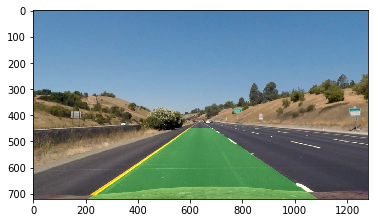

In [40]:
def draw_lane_lines(original_image, warped_image, Minv, curve_info):
    leftx = curve_info['leftx']
    rightx = curve_info['rightx']
    left_fitx = curve_info['left_fitx']
    right_fitx = curve_info['right_fitx']
    ploty = curve_info['ploty']
    
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    return result


result = draw_lane_lines(image, binary_warped, Minv, curve_info)
plt.imshow(result)


## Step 8: Pipeline and Annotation

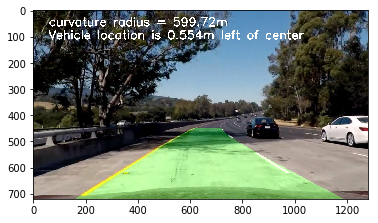

In [41]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


global used_warped
global used_curve

def add_text(result,image,left_curverad,curve_info):
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'curvature radius = ' + str(round(left_curverad, 2)) + 'm'
    cv2.putText(result, curvature_text, (60, 60), fontType, 1.5, (255, 255, 255), 3)

    # Annotating deviation
    deviation_pixels = image.shape[1]/2 - abs(curve_info['right_fitx'][-1] - curve_info['left_fitx'][-1])
    xm_per_pix = 3.7/700
    deviation = deviation_pixels * xm_per_pix
    if deviation < 0:
        direction = "left"
    else:
        direction = "right"
    deviation_text = 'Vehicle location is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (60, 110), fontType, 1.5, (255, 255, 255), 3)
 
def process_image(image):
    global used_warped
    global used_curve

    #Undistort image
    image = image_undistort(image)
    
    # Gradient thresholding    
    gradient_combined = grad_threshold(image)
   
    # Color thresholding
    s_binary = hls_select(image, thresh=(170, 255))

    # Combine Gradient and Color thresholding    
    color_binary, combined_binary = combine_threshold(s_binary, gradient_combined)

    # Transforming Perspective
    binary_warped, Minv = warp(combined_binary)

    # Getting Histogram
    histogram = plot_histogram(binary_warped)

    # Sliding Window to detect lane lines
    left_fit, right_fit = slide_window(binary_warped, histogram, draw = False)

    # Skipping Sliding Window
    curve_info = skipping_sliding_window(binary_warped, left_fit, right_fit, draw = False)

    # Measuring Curvature
    left_curverad, right_curverad = get_curvature(curve_info)

     # check if the lines are roughly parallel and have similar curvature
    slope_left = curve_info['left_fitx'][0] - curve_info['left_fitx'][-1]
    slope_right = curve_info['right_fitx'][0] - curve_info['right_fitx'][-1]
    slope_diff = abs(slope_left - slope_right)
    slope_threshold = 150
    curve_diff = abs(left_curverad - right_curverad)
    curve_threshold = 10000

    if (slope_diff > slope_threshold or curve_diff > curve_threshold):
        binary_warped = used_warped
        curve_info = used_curve

    result = draw_lane_lines(image, binary_warped, Minv, curve_info)
    # Annotating curvature
    add_text(result,image,left_curverad,curve_info)

    used_warped = binary_warped
    used_curve = curve_info


    return result

image = mpimg.imread('test_images/test5.jpg')
#image = mpimg.imread('test_images/straight_lines1.jpg')

result_image = process_image(image)
plt.imshow(result_image)

## Step 9: Convert video

In [27]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [04:21<00:00,  5.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 4min 52s, sys: 51.3 s, total: 5min 43s
Wall time: 4min 22s


Here's a [link to my video result](./result.mp4)

## Discussion
1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

During my implementation, I spend a lot of time on getting the color_binary image right. I found out that only when I convert the value into int using the following code:

out_img = out_img.astype(np.uint8)

Then it can normally display. However, I need to convert the value to int only when I need to draw them. Otherwise it will affect the final result.
